# Buscamos relacion entre el mes y el año en que parte el vuelo, y la probabilidad de que este demorado

In [1]:
import os
import sqlite3
import pandas as pd
import numpy as np                   # Para cosas de álgebra lineal
import matplotlib.pyplot as plt      # Para gráficos
import seaborn as sns                # Para gráficos lindos :^)
sns.set_style("darkgrid")
from sklearn import linear_model     # Para CML
conn = sqlite3.connect('../vuelos.db')

import warnings
warnings.filterwarnings('ignore')

In [2]:
def read_from_db(query, conn, cache_fn=None):
    if cache_fn and os.path.exists(cache_fn):
        return pd.read_csv(cache_fn)
    df = pd.read_sql_query(query, conn)
    if cache_fn:
        df.to_csv(cache_fn)
    return df

# To do:
    - Al analizar todos los años, primero mostrar como cae la cantidad de vuelos post 2001, y despues sacar todo el año (desde septiembre 2001 hasta septiembre 2002), diciendo que todo el año es un outlier y daña las metricas (me dijo nestor que estaba bien)

In [3]:
yearfrom = 1988
yearto = 2008

In [4]:
df = read_from_db('''
select o.Month as Month, o.Year as Year, count(*)*1.0/o2.amount as DelayPercentage, o2.amount as TotalAmount
from ontime o
join (select Month, Year, count(*) as amount from ontime where Year != "NA" and month != "NA" and year != 2001 and year != 2002 and year >= {yearfrom} and year <= {yearto} group by Month, Year)
  as o2 on o2.Month = o.Month and o2.Year = o.Year
where o.year != "NA" and o.month != "NA"
  and o.DepDelay >= 15
  and o.year >= {yearfrom}
  and o.year <= {yearto}
  and o.year != 2001 and o.year != 2002
  group by o.Month, o.Year
order by o.Year asc, o.Month asc;
'''.format(yearfrom=yearfrom, yearto=yearto), conn, '../data/exp/delays_1988_2008.csv')

In [5]:
df.describe()

,Unnamed: 0,Month,Year,DelayPercentage,TotalAmount
count,228.00000,228.000000,228.000000,228.000000,228.000000
mean,113.50000,6.500000,1997.631579,0.175155,486771.947368
std,65.96211,3.459648,6.264737,0.052804,73836.342838
min,0.00000,1.000000,1988.000000,0.074579,383950.000000
25%,56.75000,3.750000,1992.000000,0.136112,432916.250000
50%,113.50000,6.500000,1997.000000,0.172792,452907.500000
75%,170.25000,9.250000,2004.000000,0.204273,555672.500000
max,227.00000,12.000000,2008.000000,0.334818,653279.000000


# Analizamos los vuelos, excluyendo los años 2001 y 2002
Se agrupan los vuelos por mes y se calcula el porcentaje de vuelos demorados en dicho mes.
El 9/11 produce un outlier muy grande (del tamaño de un año o quizás más) que no es relevante para nuestro eje.
Por lo tanto entrenamos y predecimos con años distintos de 2001 y 2002.

In [6]:
def plot_datos_originales(df):
    df['period'] = pd.Series([y*12+m for (y,m) in zip(df['Year'], df['Month'])])

    #f, ax = plt.subplots(figsize=(20, 12))
    plt.figure(figsize=(20, 12))

        #ax.avxline(i*12)
    ax = sns.tsplot(time=df['period'], data=df['DelayPercentage'], interpolate=True)
    #plt.xticks([i*12 if i< 2001 else (i+2)*12 for i in range(yearfrom, yearto)], range(yearfrom, yearto))
    plt.xticks([i*12 for i in range(yearfrom, yearto+2)], range(yearfrom, yearto+2))

    for i in range(yearfrom,yearto+2):
        plt.axvline(i*12, color='black', linestyle='--')
        # Otra forma de agregar los labels:
        #plt.text(i*12+6, 0, i, horizontalalignment='center', color = 'black',size='medium', weight='semibold')
    return ax
        
#plot_datos_originales(df)
#plt.show()

# TODO: sacar outliers, quizas antes de agrupar por mes

# Hacemos CML

## Predecir

In [7]:
def armar_matriz_A(s, funcion):
    temp = []
    for t in s:
        #temp.append([np.sin(2*np.sin(t)), np.cos(t), np.sin(0.5*t), np.sin(t), t**2, t, 1])
        temp.append(funcion(t))
    return np.array(temp)

def entrenar_y_predecir_en_rangos(df, rango_entrenamiento, rango_prediccion, funcion, x='x', y='y'):
    ax = plot_datos_originales(df)

    # http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
    regr = linear_model.LinearRegression(fit_intercept=False)

    ## Entreno el modelo
    
    # Armo la matriz A de features
    df_entrenamiento = df[df[x].isin(rango_entrenamiento)]
    A = armar_matriz_A(df_entrenamiento[x], funcion)
    
    # 'Fiteo' los datos de entrenamiento
    regr.fit(A, df_entrenamiento[y])
    
    # Grafico la aproximacion
    df_entrenamiento['pred'] = regr.predict(A)
    sns.tsplot(ax=ax, time=df_entrenamiento[x], data=df_entrenamiento['pred'], color='red')

    ## Realizo predicciones
    
    # Armo la matriz A de features
    df_prediccion = df[df[x].isin(rango_prediccion)]
    A = armar_matriz_A(df_prediccion[x], funcion)
    
    # Predigo los datos de testeo
    df_prediccion['pred'] = regr.predict(A)
    
    # Grafico la prediccion
    sns.tsplot(ax=ax, time=df_prediccion[x], data=df_prediccion['pred'], color='green')

    ## Calculo el Error Cuadrático Medio
    #import pdb; pdb.set_trace()
    ECM = sum((df_prediccion['pred'] - df_prediccion[y])**2) / df_prediccion.shape[0]
    return ECM

def predecir(yearpredict, funcion):
    rango_entrenamiento = list(range(yearfrom*12,yearpredict*12+1))
    rango_prediccion = list(range(yearpredict*12+1,yearto*12))
    return entrenar_y_predecir_en_rangos(df, rango_entrenamiento, rango_prediccion, funcion, x='period', y='DelayPercentage')



0.004009774215680334


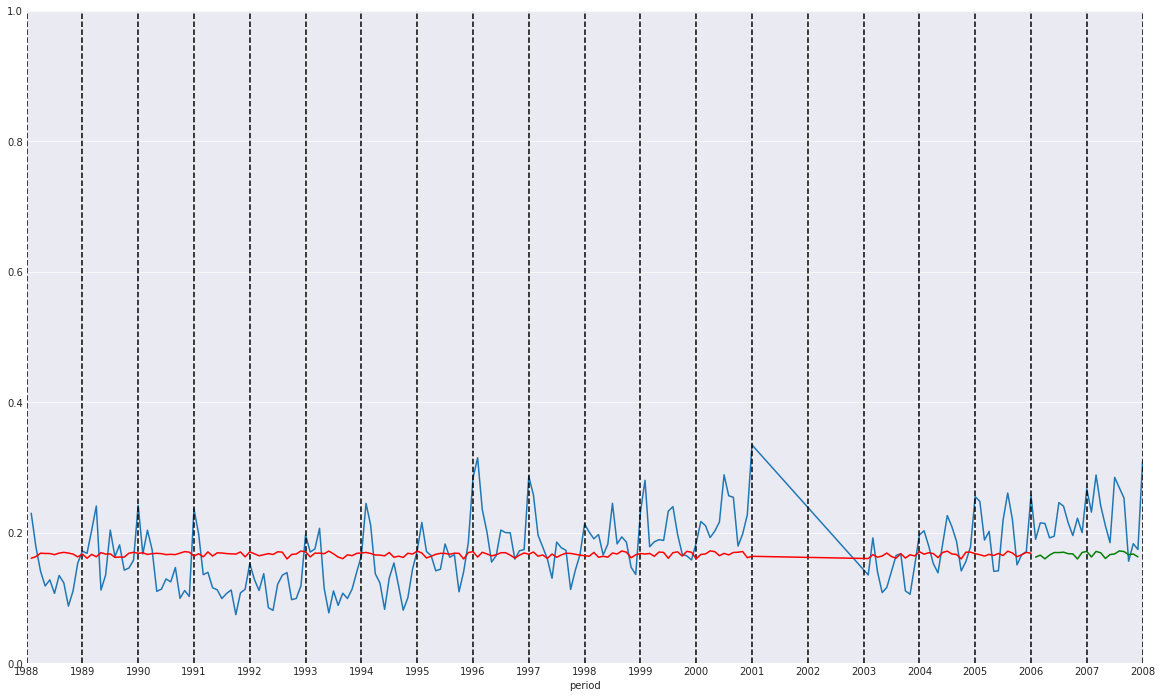

1988


In [8]:
funcion = lambda t: [np.sin(np.sin(t**2)**2), np.cos(t**2), np.sin(t**2), np.sin(t), 1]
ecm = predecir(2006, funcion)
print(ecm)
plt.xlim(yearfrom*12, yearto*12)
plt.ylim(0, 1)
plt.show()
print(yearfrom)

# Reduciendo las variables
'''Si bien en la teoría, CML funciona mejor cuanto más datos se le provea, en este caso práctico no funciona exactamente de esta manera.Parecería ser que, después de entrenar con tantos datos, la función no se anima a hacer saltos bruscos, y apuesta a la segura.
Al estar analizando tantos datos, la función que queremos estimar resulta ser demasiado errática.
Esto es provocado por la gran cantidad de varianza de porcentaje de demoras de cada mes, generada por el análisis de demasiados años.
El tráfico aéreo sufrió cambios muy radicales desde 1987 hasta 2008, por lo tanto, resulta insensato considerar que el porcentaje de vuelos demorados sigue los patrones de una función.
Los retrasos de los vuelos de 1987 es manejan en diferentes magintudes con respecto a los del 2008, tanto porque cambió la cantidad de vuelos, la forma en que se organizan en el aeropuerto, la tecnología de los aviones, etcétera.

Por lo tanto, buscamos reducir la cantidad de factores que inciden en nuestra función: Consideramos analizar los vuelos desde 2003 hasta 2007, y buscamos predecir los del período 2006-2008.
'''

In [9]:
yearfrom = 2003
yearto = 2008

0.0023495953592423875


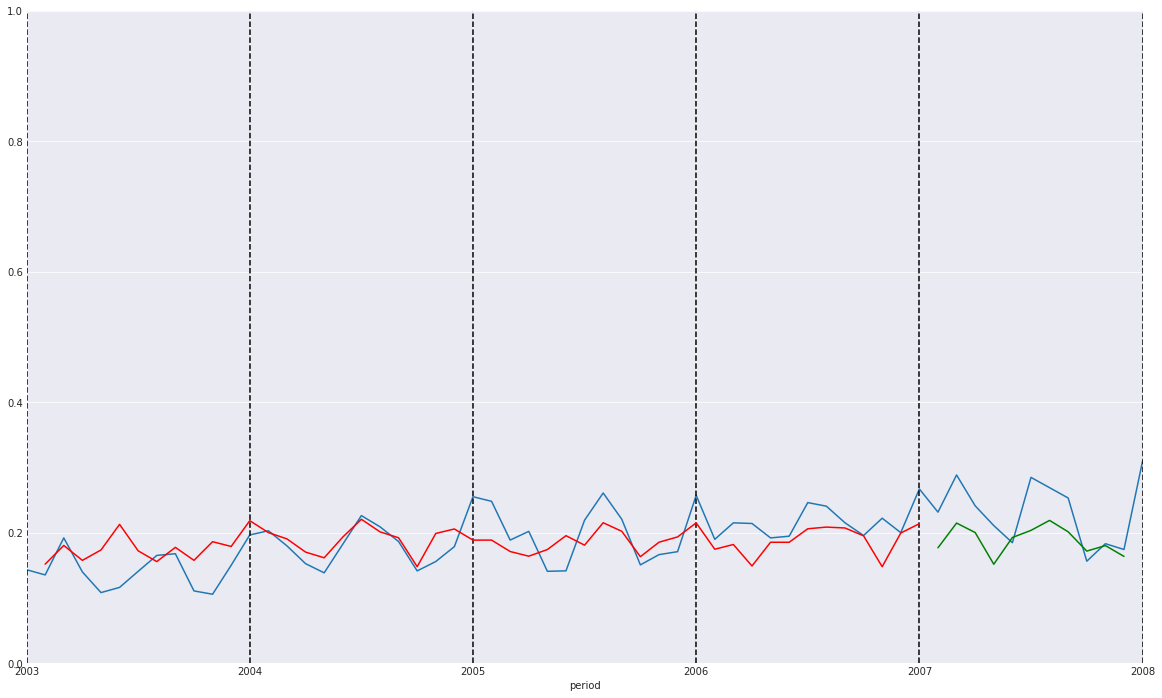

2003


In [10]:
ecm = predecir(2007, funcion)
print(ecm)
plt.xlim(yearfrom*12, yearto*12)
plt.ylim(0, 1)
plt.show()
print(yearfrom)

# Reduciendo aún más las variables
Hacemos aún más zoom: Analizamos los vuelos que parten solamente del aeropuerto de Sacramento.

In [11]:
df = read_from_db('''
select o.Month as Month, o.Year as Year, count(*)*1.0/o2.amount as DelayPercentage, o2.amount as TotalAmount
from ontime o
join (select Month, Year, count(*) as amount from ontime where Year != "NA" and month != "NA" and year != 2001 and year != 2002 and year >= {yearfrom} and year <= {yearto} and origin='{origin}' group by Month, Year)
  as o2 on o2.Month = o.Month and o2.Year = o.Year
where o.year != "NA" and o.month != "NA"
  and o.DepDelay >= 15
  and o.year >= {yearfrom}
  and o.year <= {yearto}
  and o.year != 2001 and o.year != 2002
  and origin='{origin}'
  group by o.Month, o.Year
order by o.Year asc, o.Month asc;
'''.format(yearfrom=yearfrom, yearto=yearto, origin='OAK'), conn, '../data/exp/delays_OAK_1988_2008.csv')

0.0024403549843889467


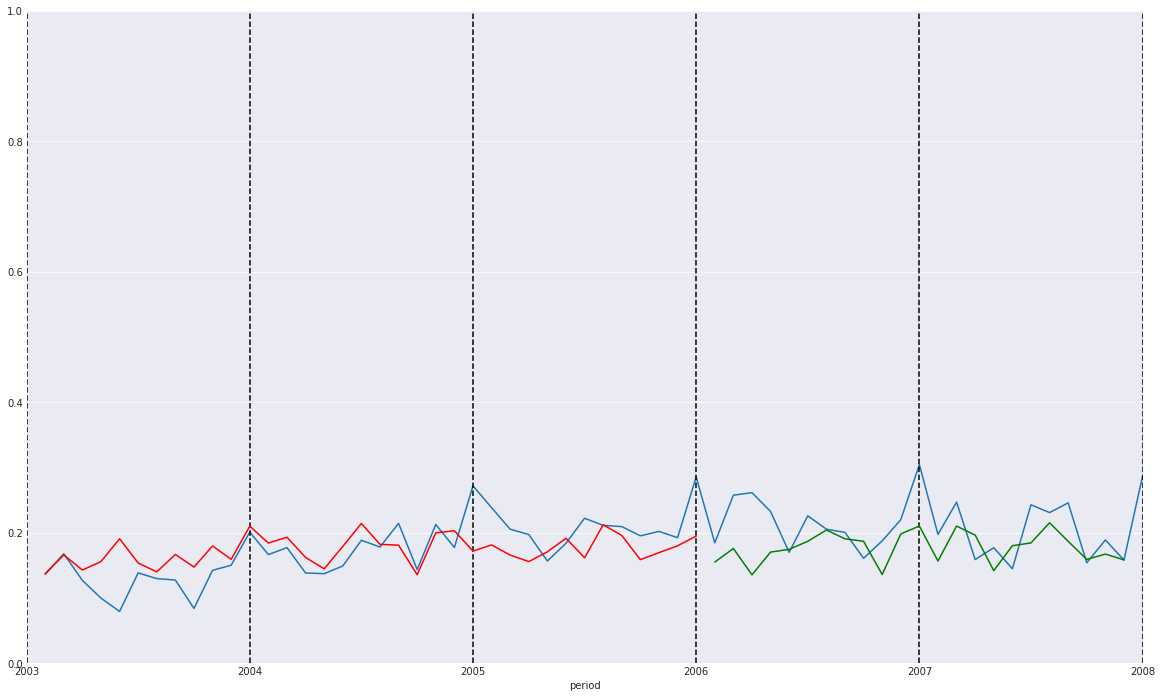

2003


In [12]:
ecm = predecir(2006, funcion)
print(ecm)
plt.xlim(yearfrom*12, yearto*12)
plt.ylim(0, 1)
plt.show()
print(yearfrom)